# Proyecto Final Riesgo de Crédito

*Helga Zambrana | Data Science*

### Objetivos del proyecto

Los objetivos de este proyecto final son:
- analizar la información disponible de los aplicantes a un préstamo e identificar las posibles variables que determinan si el solicitante no pagará el préstamo
- analizar diferentes opciones de modelos de clasificación y seleccionar el que tenga la mejor performance en predecir si el solicitante pagará o no el préstamo
- desarrollar un modelo de riesgo de crédito en Python para predecir las probabilidades de impago (PD) y asignar puntuaciones de crédito a los solicitantes existentes o potenciales

### Data Acquisition

In [69]:
# Importar librerías

# Para operaciones básicas
import numpy as np
import pandas as pd
import pandas_profiling

# Para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Para división entre train y test
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

# Ocultar los mensajes de advertencia
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

El dataset elegido fue Home Equity (HMEQ) de Kaggle: https://www.kaggle.com/datasets/ajay1735/hmeq-data  
HMEQ presenta información sobre las características y la morosidad de 5960 préstamos con garantía hipotecaria. Un préstamo con garantía hipotecaria es un préstamo en el que el deudor utiliza el capital de su vivienda como garantía subyacente.  
Los criterios de selección del dataset fueron la claridad de los datos recolectados y su robustez, lo que facilita el análisis, el procesamiento y la generación de un modelo.   
El dataset contiene las siguientes variables:
- BAD: Categoría de la persona candidata al préstamo. 1, corresponde al candidato con préstamo incumplido o con mora; 0, corresponde al candidato con préstamo al día. Se considera morosidad cuando han pasado 90 días desde que el prestamista no ha pagado.  
- LOAN: Monto en USD del préstamo solicitado
- MORTDUE: Monto en USD adeudado de la hipoteca existente
- VALUE: Monto en USD de la propiedad hipotecada
- REASON: Razón para solicitar el préstamo. DebtCon, corresponde a consolidación de deudas; HomeImp, corresponde a mejoras para el hogar
- JOB: Categoría profesional
- YOJ: Cantidad de tiempo expresado en años desde que ingresó al trabajo actual
- DEROG: Número de informes derogatorios importantes
- DELINQ: Número de líneas de crédito morosas
- CLAGE: Cantidad de tiempo expresado en meses de la línea de crédito de mayor antigüedad
- NINQ: Número de consultas crediticias recientes
- CLNO: Número de líneas de crédito
- DEBTINC: Relación deuda-ingreso. Es igual a la suma de todos los pagos de deuda del mes, dividida entre el ingreso bruto mensual


In [70]:
# Leer el dataset y crear un backup
historial_credito_backup = pd.read_csv("hmeq.csv")
historial_credito = historial_credito_backup

In [71]:
# Obtener el tamaño del dataset
print('El dataset tiene ' + str(historial_credito.shape[0]) + ' filas y ' + str(historial_credito.shape[1]) + ' columnas.')

El dataset tiene 5960 filas y 13 columnas.


In [72]:
# Mostrar información sobre el nombre de columnas, cantidad de registros que no son nulos y tipos de datos del dataset
historial_credito.info()
historial_credito.dtypes.value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


float64    9
int64      2
object     2
dtype: int64

In [73]:
# Visualizar los primeros 5 registros
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


#### *Valores duplicados y nulos*

In [74]:
#Verificar si existen datos duplicados en el dataset
historial_credito[historial_credito.duplicated()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


No existen registros duplicados en el dataset.

In [75]:
# Crear una función que muestre la información sobre valores faltantes del dataset
def get_missing_values_info(df):

    # Contar los valores faltantes en cada columna
    count_missing = df.isnull().sum()

    # Mostrar los valores faltantes como un porcentaje
    percent_missing = (100 * count_missing / df.shape[0]).round(1)

    # Crear el dataframe con los resultados 
    missing_df = pd.DataFrame({'Cantidad Datos Faltantes':count_missing,
                               'Porcentaje Datos Faltantes':percent_missing})

    # Ordenar los valores por el porcentaje de datos faltantes
    missing_df = missing_df.sort_values('Porcentaje Datos Faltantes', ascending=False)

    # Mostrar el porcentaje de columnas con valores faltantes y comparar con el número total de columnas
    missing_values_list = df.columns[df.isnull().any()].tolist()
    cols_missing_vals = len(missing_values_list)
    df_cols = df.shape[1]

    print(f'Columnas con valores faltantes: {cols_missing_vals}')
    print(f'Total de columnas: {df_cols}')
    print(f'Porcentaje de columnas con valores faltantes: {round(cols_missing_vals/df_cols*100,1)}%')

    return missing_df

get_missing_values_info(historial_credito)

Columnas con valores faltantes: 11
Total de columnas: 13
Porcentaje de columnas con valores faltantes: 84.6%


,Cantidad Datos Faltantes,Porcentaje Datos Faltantes
DEBTINC,1267,21.3
DEROG,708,11.9
DELINQ,580,9.7
MORTDUE,518,8.7
YOJ,515,8.6
NINQ,510,8.6
CLAGE,308,5.2
JOB,279,4.7
REASON,252,4.2
CLNO,222,3.7


'DEBTINC' es la variable que cuenta con mayor cantidad de valores nulos con un 21.3% del total.

<AxesSubplot:>

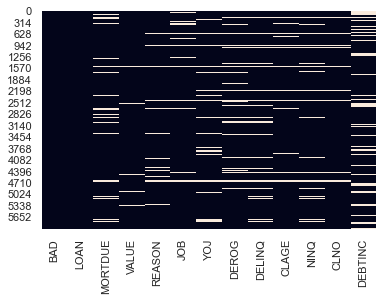

In [77]:
# Identificar los valores nulos de manera visual
sns.heatmap(historial_credito.isnull(), cbar = False)

#### *Variable target 'BAD'*

In [78]:
# Crear una función que muestre la información sobre BAD
def valoresBAD_info(df):

    # Mostrar la cantidad de registros de BAD
    count_BAD = df['BAD']. value_counts()

    # Obtener la cantidad de registros de BAD como un porcentaje
    percent_BAD = (100 * count_BAD / df.shape[0]).round(1)

    # Crear un dataframe con los resultados
    values_df = pd.DataFrame({'Cantidad':count_BAD,
                               'Porcentaje':percent_BAD})

    return values_df

valoresBAD_info(historial_credito)

,Cantidad,Porcentaje
0,4771,80.1
1,1189,19.9


Consideramos al atributo 'BAD' nuestra variable target. El mismo divide a las personas con su deuda al día (BAD = 0) de las personas con deuda morosa (BAD = 1).  
Una primera conclusión es que el dataset está desbalanceado porque solo el 19.9% del dataset representa a las personas con deuda morosa.

En porcentaje de personas con deudas morosas es de 19.95% del total de registros del dataset.

#### *División entre Train y Test*

Antes de comenzar a limpiar e imputar los datos faltantes, debemos dividir el dataset en 2 conjuntos:
- "Train", 80% del total de registros del dataset, que usaremos para entrenar nuestro modelo
- "Test", 20% del total de registros del dataset, sobre el que evaluaremos nuestro modelo entrenado

![Conjunto Train y Test](https://miro.medium.com/max/875/1*-8_kogvwmL1H6ooN1A1tsQ.png)

In [79]:
# Dividir aleatoriamente el dataset en train (80%) y test (20%) y mantener la distribución de cantidad de personas morosas en el test set
X = historial_credito.drop('BAD', axis=1)
y = historial_credito['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)
# Mostrar la cantidad de variables independientes que se usarán para entrenar el modelo
print("Cantidad de registros en X_train: ", len(X_train))
# Mostrar la cantidad de variables independientes que se usarán para realizar predicciones y testear la precisión del modelo
print("Cantidad de registros en X_test: ", len(X_test))
# Mostrar la cantidad de variables dependientes que necesitan ser predichas por este modelo, incluyendo etiquetas de categoría contra sus variables independientes
print("Cantidad de registros en y_train: ", len(y_train))
# Mostrar la cantidad de datos con etiquetas de categoría, se utilizarán para probar la precisión entre las categorías reales y las predichas.
print("Cantidad de registros en y_test: ", len(y_test))

Cantidad de registros en X_train:  4768
Cantidad de registros en X_test:  1192
Cantidad de registros en y_train:  4768
Cantidad de registros en y_test:  1192


In [80]:
# Unir x_train y y_train en un único dataframe
train_df = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
train_df

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD
609,7700,70451.00,81862.0,DebtCon,Sales,3.0,0.0,0.0,141.268671,0.0,31.0,31.681943,0
4015,21000,48735.00,71694.0,DebtCon,Other,8.0,0.0,0.0,48.498971,3.0,10.0,32.921401,1
1591,11500,63136.00,81099.0,DebtCon,Other,3.0,NaN,NaN,149.064745,NaN,35.0,28.975940,0
1127,9900,55342.00,72357.0,DebtCon,Mgr,7.0,NaN,3.0,111.998855,1.0,11.0,39.870340,0
920,9000,47350.86,105000.0,DebtCon,ProfExe,6.0,0.0,1.0,227.266667,0.0,10.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,17500,68000.00,133015.0,DebtCon,Office,19.0,1.0,1.0,177.500000,5.0,21.0,NaN,1
4301,22400,51470.00,68139.0,DebtCon,Mgr,9.0,0.0,0.0,31.168696,2.0,8.0,37.952180,1
2821,15800,NaN,44144.0,HomeImp,Other,0.0,0.0,0.0,315.812632,1.0,9.0,25.650384,0
1167,10000,147234.00,175300.0,HomeImp,Office,6.0,0.0,0.0,192.766667,1.0,56.0,NaN,0


### Data Wrangling + Análisis Exploratorio de Datos (EDA)

En esta sección prepararemos, limpiaremos y unificaremos, trataremos los outliers los datos para facilitar el acceso, el análisis y el modelado en profundidad.

#### *Tratamiento de datos faltantes en variables categóricas*

In [81]:
# Indagar los valores únicos de las variables categóricas 'REASON' Y 'JOB'
print('Los valores únicos de la variable REASON son ' + str(train_df['REASON'].unique()))
print('Los valores únicos de la variable JOB son ' + str(train_df['JOB'].unique()))

Los valores únicos de la variable REASON son ['DebtCon' 'HomeImp' nan]
Los valores únicos de la variable JOB son ['Sales' 'Other' 'Mgr' 'ProfExe' 'Self' 'Office' nan]


In [82]:
# Mostrar la cantidad de registros correspondientes a la variable categórica 'REASON' en relación a la variable target'BAD'
train_df.groupby('BAD')['REASON'].value_counts(dropna=False) 
#COMO MUESTRO PORCENTAJES?

BAD  REASON 
0    DebtCon    2534
     HomeImp    1123
     NaN         160
1    DebtCon     594
     HomeImp     322
     NaN          35
Name: REASON, dtype: int64

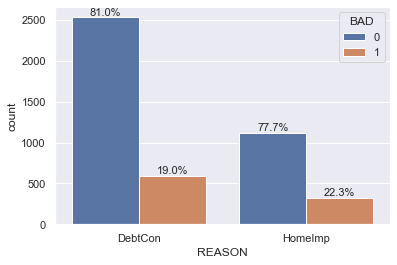

In [83]:
# Mostrar los resultados en un bar plot
sns.set_theme(style='darkgrid')

def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

ax = sns.countplot(x="REASON", hue="BAD", data=train_df)

percentage_above_bar_relative_to_xgroup(ax)
plt.show()

Según la variable 'REASON', 'DebtCon' (consolidación de deudas) es el motivo principal para solicitar un préstamo, entre quienes pagan o no sus deudas. A partir de la muestra, inferimos que si la razón es 'HomeImp' (mejoras del hogar), la diferencia entre quienes pagan y no pagan disminuye.

In [84]:
# Mostrar la cantidad de registros correspondientes a la variable categórica 'JOB' en relación a la variable target 'BAD' 
train_df.groupby('BAD')['JOB'].value_counts(dropna=False)
#COMO MUESTRO PORCENTAJES?

BAD  JOB    
0    Other      1479
     ProfExe     839
     Office      654
     Mgr         467
     NaN         213
     Self        106
     Sales        59
1    Other       458
     ProfExe     167
     Mgr         139
     Office       93
     Self         44
     Sales        33
     NaN          17
Name: JOB, dtype: int64

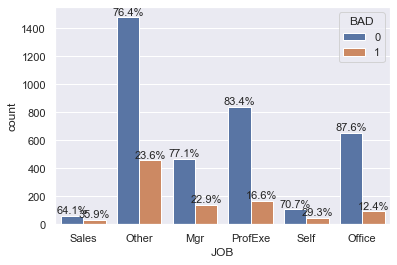

In [85]:
# Mostrar los resultados en un bar plot
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

ax = sns.countplot(x="JOB", hue="BAD", data=train_df)

percentage_above_bar_relative_to_xgroup(ax)
plt.show()

Según la variable 'JOB', inferimos que existe una tendencia levemente mayor a no pagar las deudas entre los perfiles de 'Sales' (Ventas) y 'Self' (Autónomos).

In [86]:
# Imputar variables categóricas con la moda de 'REASON' y 'JOB'
train_df['REASON'] = train_df['REASON'].fillna(train_df['REASON'].mode()[0])
train_df['JOB'] = train_df['JOB'].fillna(train_df['JOB'].mode()[0])

# Ver el contador de 'REASON' luego de la imputación de variables
train_df.groupby('BAD')['REASON'].value_counts(dropna=False) 

BAD  REASON 
0    DebtCon    2694
     HomeImp    1123
1    DebtCon     629
     HomeImp     322
Name: REASON, dtype: int64

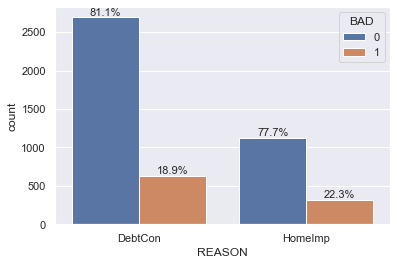

In [87]:
# Mostrar los resultados en un bar plot
sns.set_theme(style='darkgrid')

def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

ax = sns.countplot(x="REASON", hue="BAD", data=train_df)

percentage_above_bar_relative_to_xgroup(ax)
plt.show()

In [88]:
# Ver el contador de 'JOB' luego de la imputación de variables
train_df.groupby('BAD')['JOB'].value_counts(dropna=False)


BAD  JOB    
0    Other      1692
     ProfExe     839
     Office      654
     Mgr         467
     Self        106
     Sales        59
1    Other       475
     ProfExe     167
     Mgr         139
     Office       93
     Self         44
     Sales        33
Name: JOB, dtype: int64

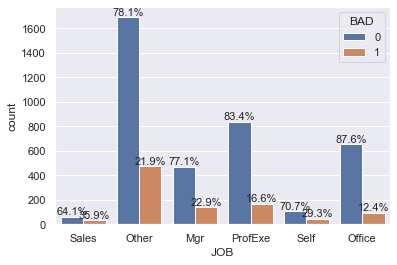

In [89]:
# Mostrar los resultados en un bar plot
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

ax = sns.countplot(x="JOB", hue="BAD", data=train_df)

percentage_above_bar_relative_to_xgroup(ax)
plt.show()

Transformaremos la variable 'YOJ' a una booleana de Empleo o Desempleo y transformaremos la variable 'CLAGE' de meses a años. 

In [137]:
#Utilizar una función lambda para agilizar el resultado
tiene_empleo = lambda x: False if x <=0 else True

#Aplicar la función a la nueva variable
train_df['Tiene_Empleo'] = train_df['YOJ'].apply(tiene_empleo)

#Crear la variable Años_Credito
train_df['Años_Credito'] = (train_df['CLAGE'] / 12)

#Presentar los resultados
train_df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,True,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,True,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,True,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,True,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,True,8.455500


#### *Tratamiento de datos faltantes en variables numéricas*

In [81]:
# Imputar los valores faltantes de la variable 'DEBTINC' con KNNImputer
imputer = KNNImputer(n_neighbors=5, weights= 'uniform')

imputer.fit(X_train[['DEBTINC']])
X_train['DEBTINC'] = imputer.transform(X_train[['DEBTINC']]).ravel()

print('Valores faltantes en DEBTINC: ' + str(X_train['DEBTINC'].isnull().sum()))

Valores faltantes en DEBTINC: 0


<AxesSubplot:xlabel='LOAN', ylabel='Density'>

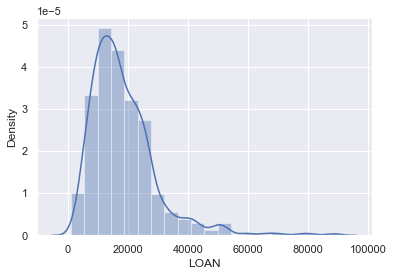

In [58]:
# Histograma estimación de densidad
sns.distplot(train_df['LOAN'], bins=20)

Se observa que el monto del préstamo se concentra entre los 1000 USD y 55000 USD.

In [67]:
# Comprobar la simetría de los datos con curtosis y distorsión
print('distorsión: %f' % train_df['LOAN'].skew())
print('curtosis: %f' % train_df['LOAN'].kurt())

distorsión: 1.965910
curtosis: 6.637139


Como la curtosis es mayor que 3, parece que 'LOAN' representa una distribución normal.

<AxesSubplot:xlabel='LOAN'>

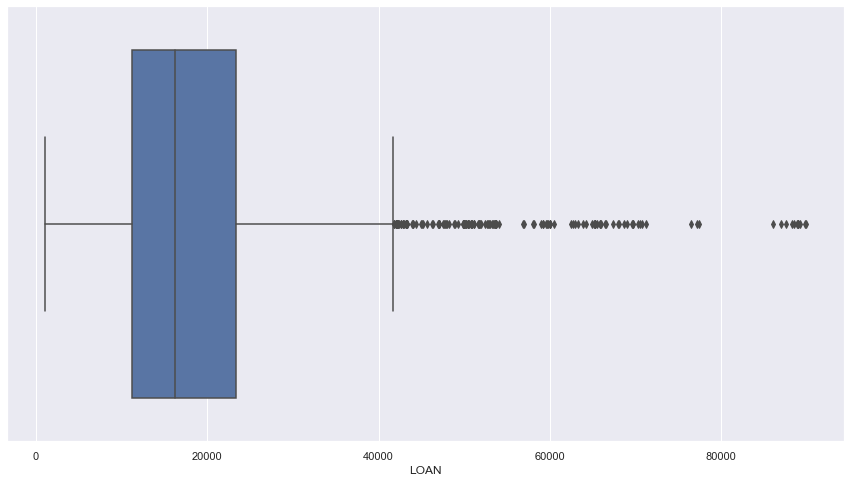

In [144]:
#Boxplot sobre los valores de los préstamos
from seaborn import boxplot
boxplot(historial_credito['LOAN'])

La media del monto de los préstamos que tienen las personas se ubica por debajo de los USD 20000. Observamos una gran dispersión hacia la izquierda, entre valores por encima de los USD 40000.

In [145]:
#Hacer visible la diferencia entre préstamos morosos y préstamos pagados
historial_credito.loc[historial_credito['BAD'] == 1, 'STATUS'] = 'MOROSO'
historial_credito.loc[historial_credito['BAD'] == 0, 'STATUS'] = 'PAGADO'
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito,STATUS
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,1,7.863889,MOROSO
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,1,10.152778,MOROSO
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,1,12.455556,MOROSO
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,1,7.777778,PAGADO
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,1,8.455500,MOROSO


#### *Análisis Multivariado*

<AxesSubplot:>

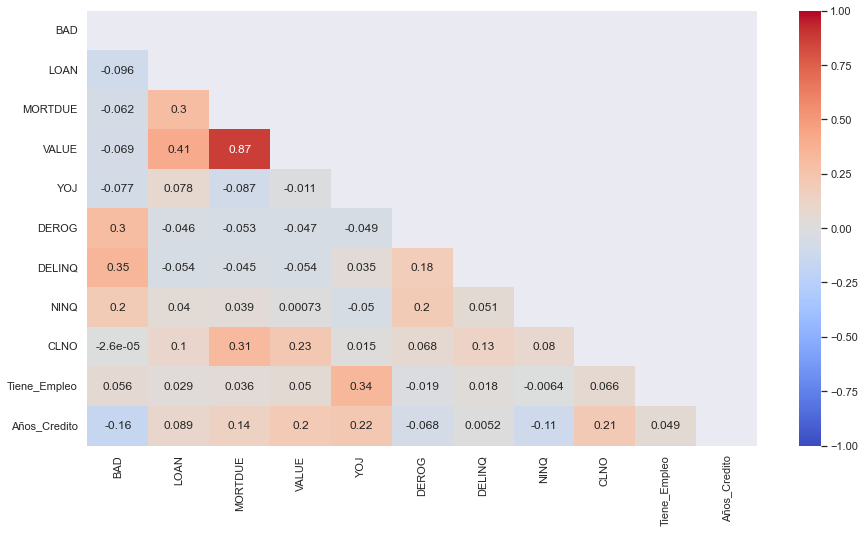

In [148]:
#Mapa de Correlación
upp_mat = np.triu(historial_credito.corr())

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(historial_credito.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

El mapa de correlaciones puede indicar una relación predictiva a ser explotada en el modelo de clasificación. Los colores más fríos corresponden a una baja correlación, los más cálidos corresponden a una alta correlación. 

Las variables relacionadas con el historial crediticio ('DELINQ', 'DEROG', 'NINQ') son las más correlacionadas con la variable target ('BAD'). Es un indicio de que éstas serán las variables de clasificación. Estas variables también están ligeramente correlacionadas entre sí sugiriendo que la información podría ser redundante.

El monto adeudado de la hipoteca existente ('MORTDUE') o el valor de la garantía subyacente ('VALUE') no parecen estar relacionados con el estado del préstamo. De todos modos, forman otro grupo de correlación con otras variables como los Años_Crédito y el número de líneas de crédito (CLNO).

#### *Estadísticas descriptivas de candidatos con préstamos pagados*

In [141]:
#Filtrar los préstamos pagados a partir de la variable 'BAD'
train_df[train_df['BAD']==0].drop('BAD', axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
count,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000
mean,19032.4626,75954.3452,107528.8771,9.3108,0.1048,0.2157,1.0082,22.1256,0.9181,15.3406
std,10863.4585,44495.8932,53831.1805,7.6620,0.3936,0.6059,1.4620,9.1293,0.2742,6.7339
min,1700.0000,2619.0000,26000.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0406
25%,11900.0000,49000.0000,71355.0000,3.0000,0.0000,0.0000,0.0000,16.0000,1.0000,10.1470
50%,16900.0000,67285.0000,94613.0000,8.0000,0.0000,0.0000,1.0000,21.0000,1.0000,15.0609
75%,23800.0000,92693.5000,122328.5000,14.0000,0.0000,0.0000,2.0000,27.0000,1.0000,19.4947
max,89900.0000,371003.0000,471827.0000,36.0000,3.0000,4.0000,11.0000,56.0000,1.0000,54.1456


#### *Estadísticas descriptivas de candidatos con préstamos morosos*

In [142]:
#Filtrar los préstamos morosos a partir de la variable 'BAD'
train_df[train_df['BAD']==1].drop('BAD', axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
count,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000
mean,16389.4048,68966.4455,97955.4343,7.8549,0.6762,1.1488,1.8440,22.1250,0.9548,12.4777
std,10861.3966,47625.8831,60299.8026,6.8546,1.4318,1.8631,2.2172,11.3532,0.2079,7.3822
min,1100.0000,2800.0000,12500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,9000.0000,39552.0000,60498.2500,2.5000,0.0000,0.0000,0.0000,14.0000,1.0000,7.8784
50%,14600.0000,59374.5000,83000.0000,6.0000,0.0000,0.0000,1.0000,21.0000,1.0000,11.0011
75%,20650.0000,84985.5000,118031.2500,11.2500,1.0000,2.0000,3.0000,28.0000,1.0000,16.1591
max,77400.0000,399412.0000,512650.0000,41.0000,10.0000,15.0000,13.0000,65.0000,1.0000,97.3528


De las estadísticas descriptivas se pueden comenzar a perfilar algunas definiciones:

- La media de las variables de préstamo solicitado ('LOAN'), importe vencido de la hipoteca ('MORTDUE') y valor de la garantía ('VALUE') es mayor en el caso de las muestras de préstamos PAGADOS. Al tratarse de valores que no son significativamente diferentes, puede no existir un potencial para categorización.

- La media de años en el puesto de trabajo actual ('YOJ') sugiere que los préstamos MOROSOS son más frecuentes en los aplicantes con una menor antigüedad en sus trabajos actuales. Esta tendencia se observa también en los cuartiles.

- Luego, se puede observar el caso de las variables relacionadas con el historial crediticio de la persona que solicita el préstamo, como el número de informes derogatorios importantes ('DEROG'), el número de líneas de crédito en mora ('DELINQ'), la antigüedad de la línea de crédito ('CLAGE') y el número de consultas de crédito recientes ('NINQ'). En el caso de los préstamos MOROSOS, la distribución de estas variables sugiere un sesgo hacia peores historiales de crédito comparados con la distribución correspondiente para los préstamos PAGADOS.

- Finalmente, el la media de líneas de crédito abiertas ('CLNO') es similar en ambos casos, con lo que tampoco existiría un potencial significativo para categorización.